In [138]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import warnings
warnings.filterwarnings('ignore')

In [139]:
path = '../data/kmrd-small/'
df = pd.read_csv(path + 'rates.csv')

In [140]:
# Load all related dataframe
movies_df = pd.read_csv(os.path.join(path, 'movies.txt'), sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')

castings_df = pd.read_csv(os.path.join(path, 'castings.csv'), encoding='utf-8')
countries_df = pd.read_csv(os.path.join(path, 'countries.csv'), encoding='utf-8')
genres_df = pd.read_csv(os.path.join(path, 'genres.csv'), encoding='utf-8')

# Get genre information
genres = [(list(set(x['movie'].values))[0], '/'.join(x['genre'].values)) for index, x in genres_df.groupby('movie')]
combined_genres_df = pd.DataFrame(data=genres, columns=['movie', 'genres'])
combined_genres_df = combined_genres_df.set_index('movie')

# Get castings information
castings = [(list(set(x['movie'].values))[0], x['people'].values) for index, x in castings_df.groupby('movie')]
combined_castings_df = pd.DataFrame(data=castings, columns=['movie','people'])
combined_castings_df = combined_castings_df.set_index('movie')

# Get countries for movie information
countries = [(list(set(x['movie'].values))[0], ','.join(x['country'].values)) for index, x in countries_df.groupby('movie')]
combined_countries_df = pd.DataFrame(data=countries, columns=['movie', 'country'])
combined_countries_df = combined_countries_df.set_index('movie')

movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)

print(movies_df.shape)
print(movies_df.head())

(999, 7)
                      title                           title_eng    year  \
movie                                                                     
10001                시네마 천국              Cinema Paradiso , 1988  2013.0   
10002              빽 투 더 퓨쳐           Back To The Future , 1985  2015.0   
10003            빽 투 더 퓨쳐 2    Back To The Future Part 2 , 1989  2015.0   
10004            빽 투 더 퓨쳐 3  Back To The Future Part III , 1990  1990.0   
10005  스타워즈 에피소드 4 - 새로운 희망                    Star Wars , 1977  1997.0   

         grade         genres  \
movie                           
10001   전체 관람가     드라마/멜로/로맨스   
10002  12세 관람가         SF/코미디   
10003  12세 관람가         SF/코미디   
10004   전체 관람가  서부/SF/판타지/코미디   
10005       PG   판타지/모험/SF/액션   

                                                  people   country  
movie                                                               
10001  [4374, 178, 3241, 47952, 47953, 19538, 18991, ...  이탈리아,프랑스  
10002    [1076, 4603, 917,

In [141]:
movies_df.columns

Index(['title', 'title_eng', 'year', 'grade', 'genres', 'people', 'country'], dtype='object')

- factorization machine -> feature vector
- feature vector: user onehot vector + item onehot vector + meta info + other feature engineered vetors

In [142]:
movies_df['genres'].head()

movie
10001       드라마/멜로/로맨스
10002           SF/코미디
10003           SF/코미디
10004    서부/SF/판타지/코미디
10005     판타지/모험/SF/액션
Name: genres, dtype: object

In [143]:
dummy_genres_df = movies_df['genres'].str.get_dummies(sep='/')
dummy_genres_df.head()

,SF,가족,공포,느와르,다큐멘터리,드라마,로맨스,멜로,모험,뮤지컬,...,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
movie,,,,,,,,,,,,,,,,,,,,,
10001,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10002,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10003,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10004,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
10005,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [144]:
movies_df['grade'].unique()

array(['전체 관람가', '12세 관람가', 'PG', '15세 관람가', 'NR', '청소년 관람불가', 'PG-13',
       'R', 'G', nan], dtype=object)

In [145]:
dummy_grade_df = pd.get_dummies(movies_df['grade'], prefix='grade')
dummy_grade_df.head()

,grade_12세 관람가,grade_15세 관람가,grade_G,grade_NR,grade_PG,grade_PG-13,grade_R,grade_전체 관람가,grade_청소년 관람불가
movie,,,,,,,,,
10001,0,0,0,0,0,0,0,1,0
10002,1,0,0,0,0,0,0,0,0
10003,1,0,0,0,0,0,0,0,0
10004,0,0,0,0,0,0,0,1,0
10005,0,0,0,0,1,0,0,0,0


## FM 형식으로 변환
- user -> onehot vector
- item -> onehot vector
- movies_df에서 카테고리 피쳐 생성

In [146]:
df.head()

,user,movie,rate,time
0,0,10003,7,1494128040
1,0,10004,7,1467529800
2,0,10018,9,1513344120
3,0,10021,9,1424497980
4,0,10022,7,1427627340


In [147]:
# train_df = train_df[:1000]
df['movie'].apply(lambda x: dummy_genres_df.loc[x])

,SF,가족,공포,느와르,다큐멘터리,드라마,로맨스,멜로,모험,뮤지컬,...,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
2,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140705,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
140706,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
140707,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
140708,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [148]:
test_df = pd.get_dummies(df['user'], prefix='user')
test_df.head()

,user_0,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9,...,user_52018,user_52019,user_52020,user_52021,user_52022,user_52023,user_52024,user_52025,user_52026,user_52027
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
test_df = pd.get_dummies(df['movie'], prefix='movie')
test_df.head()

,movie_10001,movie_10002,movie_10003,movie_10004,movie_10005,movie_10006,movie_10007,movie_10008,movie_10009,movie_10011,...,movie_10978,movie_10979,movie_10980,movie_10981,movie_10982,movie_10983,movie_10985,movie_10988,movie_10994,movie_10998
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
X = pd.concat([
    pd.get_dummies(df['user'], prefix='user'),
    pd.get_dummies(df['movie'], prefix='movie'),
    df['movie'].apply(lambda x: dummy_genres_df.loc[x]),
    df['movie'].apply(lambda x: dummy_grade_df.loc[x])], axis=1)


In [151]:
# 평균 평점이 높아 10만 1로 준다
# loss 계산을 위해 0이 아닌 -1로 지정
y = df['rate'].apply(lambda x: 1 if x > 9 else -1)
print(X.shape)
print(y.shape)

# 0이 아닌 데이터 위치 확인
X_sparse = scipy.sparse.csr_matrix(X.values)

(140710, 52658)
(140710,)


In [152]:
X_sparse

<140710x52658 sparse matrix of type '<class 'numpy.int64'>'
	with 801795 stored elements in Compressed Sparse Row format>

In [153]:
X_train_sparse, X_test_sparse, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42, shuffle=True)

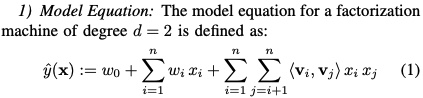


In [154]:
def log_loss(pred, y):
    return np.log(np.exp(-pred * y) + 1.0)

In [155]:

def sgd(X, y, n_samples, n_features, w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    data = X.data # 0이 아닌 원소 값
    indptr = X.indptr # 0이 아닌 원소의 행의 시작 위치
    indices = X.indices # 0이 아닌 원소의 열 위치
    loss = 0.0

    for i in range(n_samples):
        pred, summed = predict(X, w0, w, v, n_factors, i)

        # loss, gradient 계산
        loss += log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)

        # bias/intercept 갱신
        w0 -= learning_rate * loss_gradient

        # weight 갱신
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # factor 갱신
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i+1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])

    loss /= n_samples
    return loss

In [156]:
def predict(X, w0, w, v, n_factors, i):
    data = X.data
    indptr = X.indptr
    indices = X.indices
    # single instance 계산
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # w * x
    pred = 0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term ** 2

        pred += 0.5 * (summed[factor] ** 2 - summed_squared[factor])

    return pred, summed

In [157]:
# FM 학습
# X -> sparse csr matrix, y -> label
def fit(X, y, config):
    epochs = config['num_epochs']
    num_factors = config['num_factors']
    learning_rate = config['learning_rate']
    reg_weights = config['reg_weights']
    reg_features = config['reg_features']

    num_samples, num_features = X.shape
    weights = np.zeros(num_features)
    global_bias = 0.0

    feature_factors = np.random.normal(size = (num_factors, num_features))

    epoch_loss = []
    for epoch in range(epochs):
        loss = sgd(X, y, num_samples,
         num_features, global_bias, weights, feature_factors, num_factors, learning_rate, reg_weights, reg_features)
        print(f"[epoch: {epoch+1}], loss: {loss}")

        epoch_loss.append(loss)

    return epoch_loss

In [158]:
config = {
    "num_epochs": 10,
    "num_factors": 10,
    "learning_rate": 0.1,
    "reg_weights": 0.01,
    "reg_features": 0.01
}

In [160]:
epoch_loss = fit(X_train_sparse, y_train.values, config)

[epoch: 1], loss: 1.1722755698580791
[epoch: 2], loss: 0.7648286009310984
[epoch: 3], loss: 0.6307126970352159
[epoch: 4], loss: 0.5425609327468364
[epoch: 5], loss: 0.47867914796458827
[epoch: 6], loss: 0.4295239089756728
[epoch: 7], loss: 0.3901124816647124
[epoch: 8], loss: 0.3585458472932134
[epoch: 9], loss: 0.33310567631862475
[epoch: 10], loss: 0.31210670070198815


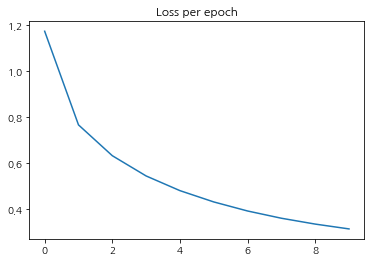

In [161]:
import matplotlib.pyplot as plt
plt.plot(epoch_loss)
plt.title('Loss per epoch')
plt.show()

# FastFM

In [162]:
from fastFM import sgd, als

In [164]:
df.shape

(140710, 4)

In [171]:
# X_train이 csc matrix여야 함
X_csc_sparse = scipy.sparse.csc_matrix(X.values)
X_csc_sparse

<140710x52658 sparse matrix of type '<class 'numpy.int64'>'
	with 801795 stored elements in Compressed Sparse Column format>

In [172]:
X_train_sparse, X_test_sparse, y_train, y_test = train_test_split(X_csc_sparse, y, test_size=0.2, random_state=42, shuffle=True)
print(X_train_sparse.shape)
print(X_test_sparse.shape)
print(y_train.shape)
print(y_test.shape)

(112568, 52658)
(28142, 52658)
(112568,)
(28142,)


In [173]:
fm = sgd.FMRegression(n_iter=10, init_stdev=0.1, rank=10, l2_reg_w=0.01, l2_reg_V=0.01)
fm.fit(X_train_sparse, y_train.values)

FMRegression(l2_reg_V=0.01, l2_reg_w=0.01, n_iter=10, rank=10)

In [174]:
y_pred = fm.predict(X_test_sparse)

In [175]:
y_test

87069     1
44148     1
92462     1
62922    -1
89565     1
         ..
27811     1
10627    -1
24184    -1
107702    1
31326     1
Name: rate, Length: 28142, dtype: int64

In [176]:
y_pred

array([-0.08064296,  0.58755726,  0.40379216, ...,  0.26078786,
        0.25474378,  0.88840391])

In [177]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

0.9679859703454343